In [1]:
import torch
import torch.nn as nn
import torchvision
from model_file import model
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


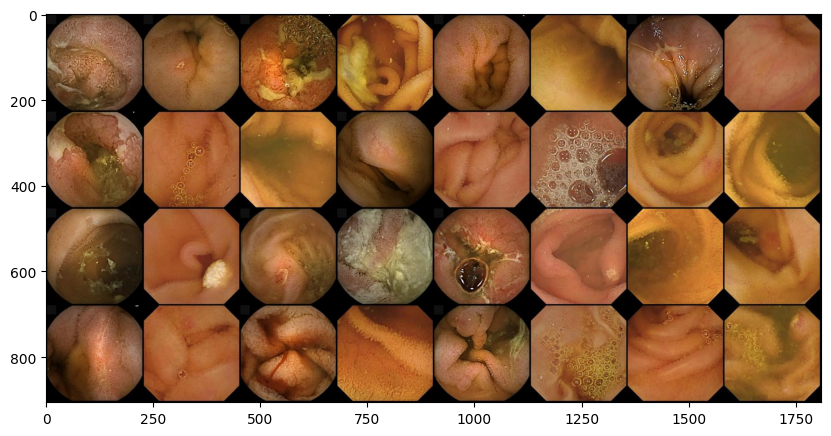

In [2]:
binaryDL_train = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/training",batch_size=32)
binaryDL_val = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/validation",batch_size=32)
visualize_batch(binaryDL_train, nrow = 8)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
sum = 0
for images, labels in binaryDL_train:
    print(images.shape)  # Should print [batch_size, 1, 48, 48]
    print(labels.shape)  # Should print [batch_size]
    sum = sum + torch.sum(labels)
    break
print(sum)

torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor(11)


In [5]:
# print(labels)

In [6]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [7]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# model

In [9]:
num_epochs = 20

In [10]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    
    for inputs, labels in binaryDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in binaryDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/20]
Train Loss: 0.4110, Train Accuracy: 0.8293
Validation Loss: 0.6347, Validation Accuracy: 0.8335
Epoch [2/20]
Train Loss: 0.2978, Train Accuracy: 0.8851
Validation Loss: 0.3036, Validation Accuracy: 0.8825
Epoch [3/20]
Train Loss: 0.2454, Train Accuracy: 0.9078
Validation Loss: 0.2265, Validation Accuracy: 0.9187
Epoch [4/20]
Train Loss: 0.2244, Train Accuracy: 0.9129
Validation Loss: 0.2247, Validation Accuracy: 0.9191
Epoch [5/20]
Train Loss: 0.1972, Train Accuracy: 0.9264
Validation Loss: 0.2165, Validation Accuracy: 0.9217
Epoch [6/20]
Train Loss: 0.1754, Train Accuracy: 0.9352
Validation Loss: 0.2255, Validation Accuracy: 0.9122
Epoch [7/20]
Train Loss: 0.1564, Train Accuracy: 0.9405
Validation Loss: 0.1760, Validation Accuracy: 0.9356
Epoch [8/20]
Train Loss: 0.1469, Train Accuracy: 0.9441
Validation Loss: 0.1885, Validation Accuracy: 0.9231
Epoch [9/20]
Train Loss: 0.1335, Train Accuracy: 0.9484
Validation Loss: 0.3064, Validation Accuracy: 0.8920
Epoch [10/20]
Train

In [11]:
PATH = "Binary10.pt"
torch.save({
            'epoch': num_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [12]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

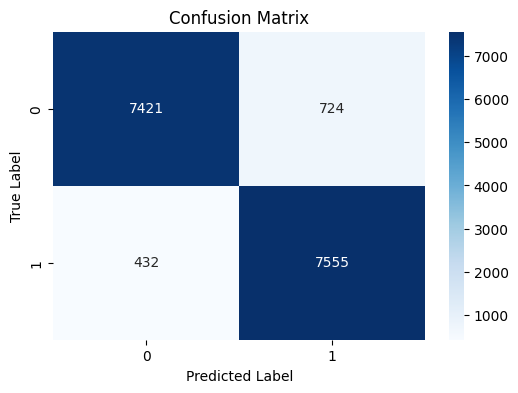

In [13]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, binaryDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()